In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.kny import KNYImage
from ganime.data.mnist import MovingMNISTImage
from ganime.utils.statistics import dataset_statistics
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.net2net import Net2Net
import tensorflow as tf
import tensorflow_addons as tfa
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [4]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7'), communication = CommunicationImplementation.AUTO


2022-05-31 10:11:08.488543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-31 10:11:11.137559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-31 10:11:11.138871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-05-31 10:11:11.139852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [6]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image_transformer.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = 128

In [7]:
train_ds = MovingMNISTImage("../../../data", batch_size=batch_size, split="train")
test_ds = MovingMNISTImage("../../../data", batch_size=batch_size, split="test")

In [8]:
with strategy.scope():
    model = Net2Net(**cfg["model"])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.


2022-05-31 10:11:16.806834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:11:18.040392: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


VQLPIPSWithDiscriminator running with hinge loss.


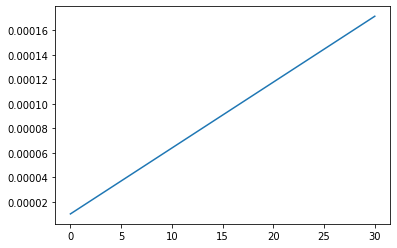

In [9]:
lrs = [model.scheduled_lrs(i) for i in range(71 * 30)]
xs = np.linspace(0, 30, len(lrs))
plt.plot(xs, lrs)

In [10]:
from ganime.utils.callbacks import TensorboardImage, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/", experiment_name="transformer_mnist")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, early_stopping, checkpointing]

In [11]:
#with strategy.scope():
#    model.compile(optimizer=tfa.optimizers.AdamW(
#        learning_rate=1e-3, weight_decay=1e-4
#    ))

def get_codebook_entry(indices, shape):
    num_embeddings = 128
    embeddings = model.first_stage_model.quantize.embeddings
    #min_encodings = tf.one_hot(indices, num_embeddings)
    #quantized = tf.matmul(min_encodings, embeddings, transpose_b=True)
    #return quantized
    encodings = tf.gather(embeddings, indices)
    return tf.reshape(encodings, shape)

encoded, _ = model.first_stage_model.encode(train_ds[0][0])
display_images(model.first_stage_model.decode(encoded))
plt.show()

display_images(model.first_stage_model.decode(get_codebook_entry(z_indices, quant_z.shape)))
plt.show()

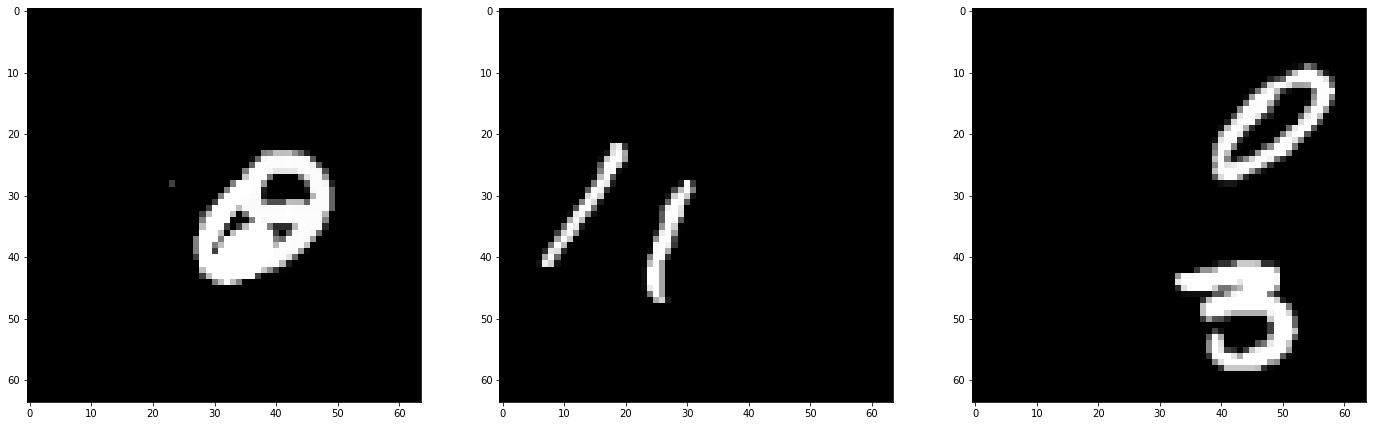

In [12]:
display_images(train_ds[0][0], 1, 3)
plt.show()

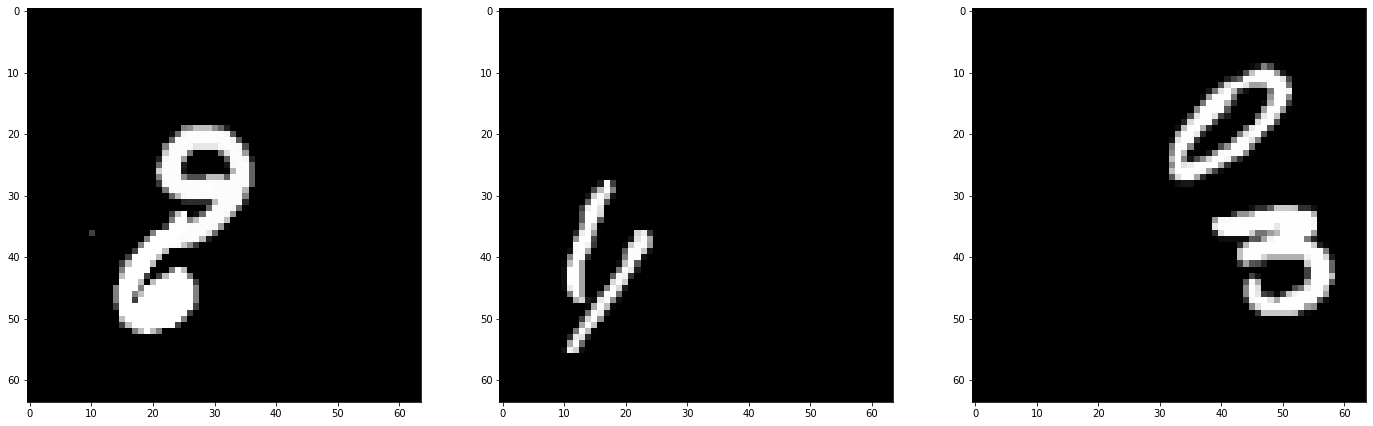

In [13]:
display_images(train_ds[0][1], 1, 3)
plt.show()

In [14]:
with strategy.scope():
    model.first_stage_model.build(input_shape=(None, *train_ds[0][0].shape[1:]))
    model.cond_stage_model.build(input_shape=(None, *train_ds[0][0].shape[1:]))

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 

In [15]:
with strategy.scope():
    model(train_ds[0])

In [16]:
model.fit(train_ds, validation_data=test_ds, epochs=2, callbacks=callbacks)

2022-05-31 10:11:29.882029: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_91415"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1

Epoch 1/2
INFO:tensorflow:Collective all_reduce tensors: 196 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =8, group_size = 8, implementation = AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 196 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =8, group_size = 8, implementation = AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, gro

2022-05-31 10:13:11.885466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:13:12.775651: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:13:13.545045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:13:14.362901: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:13:15.639984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:13:16.339405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-05-31 10:13:16.801620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


71/71 [==============================] - ETA: 0s - loss: 4.2882

2022-05-31 10:14:12.150056: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_289048"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:63"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
71/71 [==============================] - 195s 1s/step - loss: 4.2882 - val_loss: 3.3339
Epoch 2/2
71/71 [==============================] - 54s 768ms/step - loss: 3.0377 - val_loss: 2.8629


In [17]:
test_data = train_ds[0][0][0:9], train_ds[0][1][0:9]

In [18]:
x, c = test_data
quant_z, z_indices = model.encode_to_z(x)
_, c_indices = model.encode_to_c(c)

cz_indices = tf.concat((c_indices, z_indices), axis=1)
logits = model.transformer(cz_indices)

In [19]:
probs = tf.keras.activations.softmax(logits)

In [20]:
_, generated_indices = tf.math.top_k(probs)

In [21]:
generated_indices = tf.reshape(generated_indices, (-1, 128))

In [28]:
quant = model.first_stage_model.quantize.get_codebook_entry(generated_indices[:, c.shape[1]:], shape=quant_z.shape) 
#quant = model.first_stage_model.quantize.get_codebook_entry(z_indices, shape=quant_z.shape) 

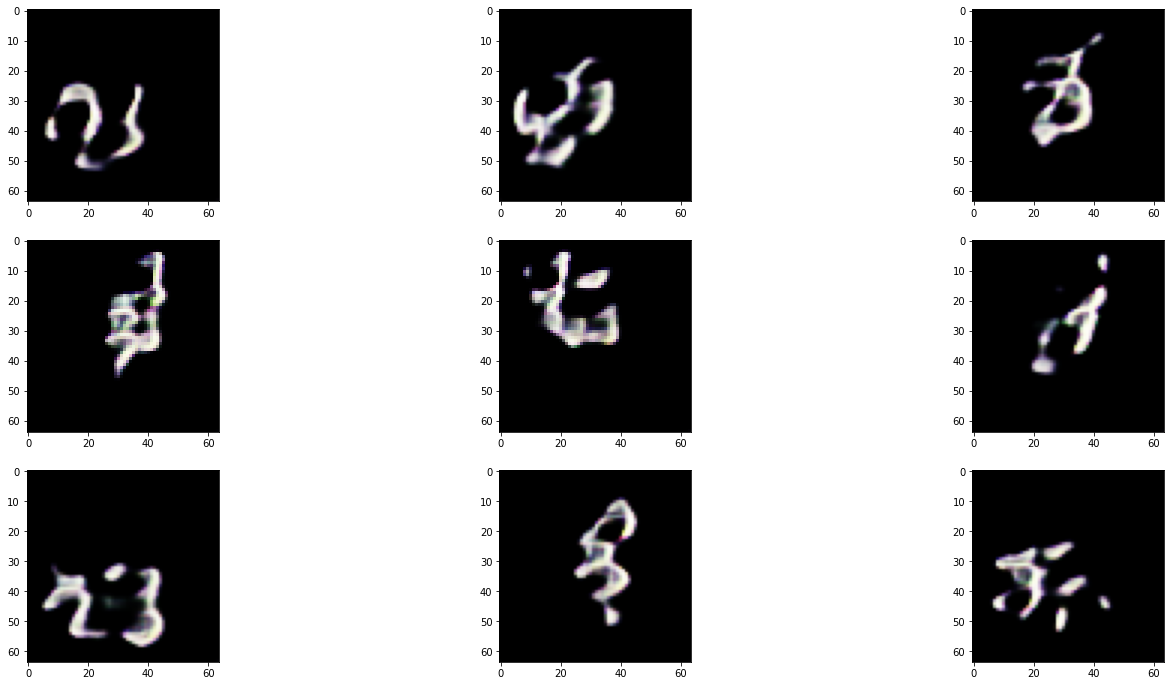

In [29]:
display_images(model.first_stage_model.decode(quant))
plt.show()

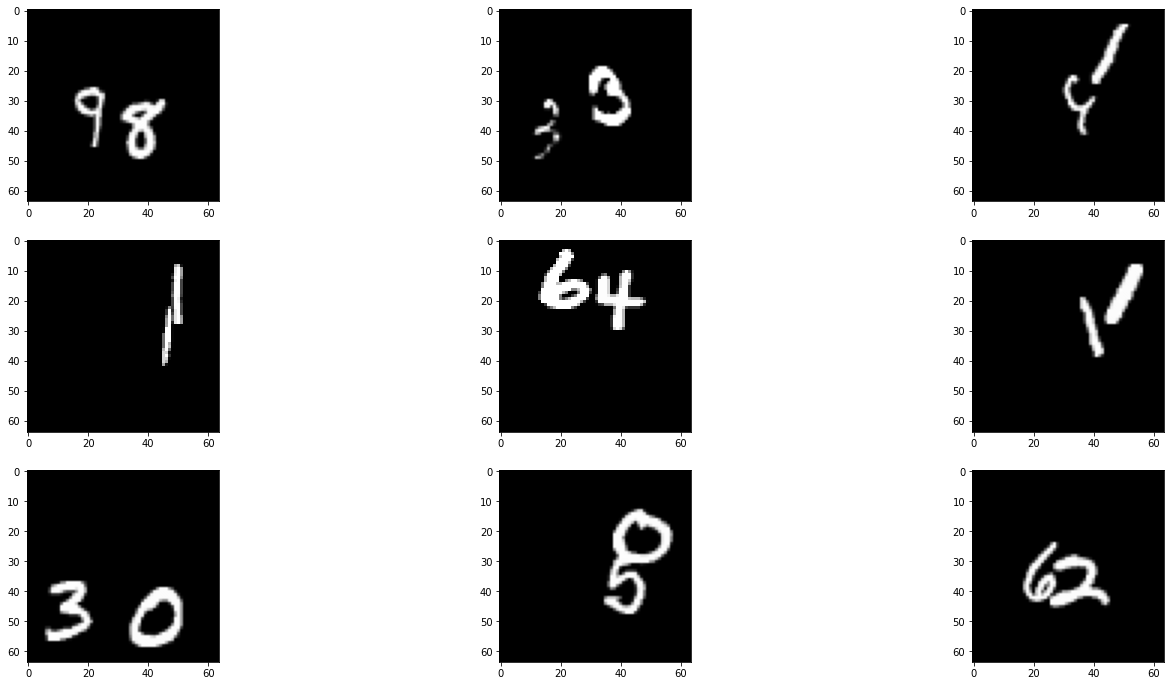

In [27]:
display_images(test_data[0])
plt.show()

In [139]:
def get_codebook_entry(indices, shape):
    num_embeddings = 128
    embeddings = model.first_stage_model.quantize.embeddings
    #quant = tf.nn.embedding_lookup(embeddings, indices)
    #quant = tf.reshape(quant, shape)
    #return quant
    encodings = tf.one_hot(indices, num_embeddings)
    quantized = tf.matmul(encodings, embeddings, transpose_b=True)
    quantized = tf.reshape(quantized, shape)
    return quantized

In [145]:
quant = get_codebook_entry(generated_indices[:, c.shape[1]:], shape=quant_z.shape)